In [2]:
import sys
sys.path.append("/glade/work/zhixing/python_scripts/SOM-SEASONAL/User-defined/")  ## import some already written functions
from Synoptic_regimes import *

In [5]:
rain, time, lons_wrf, lats_wrf = extract_wrf_rainnc_data(variable = 'precipitation') ## extract the hourly precip from WRF output


NODE1_NUM = 2; NODE2_NUM = 2

w_x = np.load('/glade/work/zhixing/python_scripts/temp_w_x.npy')  ## the x-position for each pattern
w_y = np.load('/glade/work/zhixing/python_scripts/temp_w_y.npy')  ## the y-position for each pattern

# #-- get the index for each node
#-#
dic_cluster, dic_time = Link_processing(NODE1=NODE1_NUM , NODE2 = NODE2_NUM, w_x = w_x, w_y = w_y, time = time)

Link data with cluster	 Finished...



In [6]:
%%time
def data_processing(switch, switch2):
    # read data file
    """ here, we read RAINNC_snowie_Timely.nc, "RAINNC" is "ACCUMULATED TOTAL GRID SCALE PRECIPITATION"
    The choose of variables decide which patterns you want to "organize" (ground precipitation pattern or geopotential height pattern)
    """
    f_rain    = xr.open_dataset("/glade/work/zhixing/Analysis_DATA/SNOWIE_seasonal_Data/vars-merge/RAINNC_snowie_Timely.nc")
    f_snow    = xr.open_dataset("/glade/work/zhixing/Analysis_DATA/SNOWIE_seasonal_Data/vars-merge/SNOWNC_Timely.nc")
    # read original 3d data 
    rain = f_rain.variables['RAINNC_TIMELY'] # Units: mm
    snow = f_snow.variables['SNOWNC_TIMELY']
    lons = f_rain.variables['XLONG']; lats = f_rain.variables['XLAT']; time = f_rain.variables['Time']
    print("the original data shape:",rain.shape)
    
    sel_rain  = rain[:].data 
    sel_time  = time[:].data
    sel_snow  = snow[:].data

    ###*********** find out index from January to March...
    if switch == 'Jan-March':
        Jan   = np.datetime64('2017-01-01', 'ns')
        Mar   = np.datetime64('2017-04-01', 'ns')
        time_ind  = np.where((sel_time>=Jan) & (sel_time<Mar))
        sel_time  = sel_time[time_ind]
        sel_rain  = sel_rain[time_ind]
        sel_snow  = sel_snow[time_ind]
        print("choose from Jan. to Mar. :", sel_rain.shape) ## we choose the data period from January to March
   
    if switch2 == 'Payette':
        ind_lon = np.where((lons[-1]>=-117) & (lons[-1]<=-114)) ## lons_W = -117, lons_E = -114
        ind_lat = np.where((lats[:,0]>=43) & (lats[:,0]<=45)) ## lats_S = 43, lats_N = 45, select a rectangle region of interest
        ind_lat_s = ind_lat[0][0]; ind_lat_e = ind_lat[0][-1]+1; ind_lon_s = ind_lon[0][0]; ind_lon_e = ind_lon[0][-1]+1 
        lons      = lons[ind_lat_s:ind_lat_e, ind_lon_s:ind_lon_e]
        lats      = lats[ind_lat_s:ind_lat_e, ind_lon_s:ind_lon_e]
        sel_rain  = sel_rain[:,ind_lat_s:ind_lat_e, ind_lon_s:ind_lon_e]
        print("Payette region data shape:",sel_rain.shape)
     
    sel_time  = np.array(sel_time, dtype='datetime64[s]')
    dim_0 = sel_rain.shape[0]; dim_1 = sel_rain.shape[1]; dim_2 = sel_rain.shape[2]
    print("Data processing: get the ground snow and precipitation \t Finished..")
    return sel_rain,  sel_snow, dim_0, dim_1, dim_2,  lons, lats


def Plot_preprocessing():
    ##--- read the integrated water vapor transportation data
    #---
    #*** here, we utilized the revised IVMFT (integrated between surface and 300 hPa)
    IVMFT_file_v5 = "/glade/work/zhixing/Analysis_DATA/SNOWIE_seasonal_Data/Post-processing_data/revised_IVMFT_v5.npy"
    IVMFT_file_v4 = "/glade/work/zhixing/Analysis_DATA/SNOWIE_seasonal_Data/Post-processing_data/revised_IVMFT_v4.npy"
    IVMFT_file_v3 = "/glade/work/zhixing/Analysis_DATA/SNOWIE_seasonal_Data/Post-processing_data/revised_IVMFT_v3.npy"
    IVMFT_file_v2 = "/glade/work/zhixing/Analysis_DATA/SNOWIE_seasonal_Data/Post-processing_data/revised_IVMFT_v2.npy"
    IVMFT_file_v1 = "/glade/work/zhixing/Analysis_DATA/SNOWIE_seasonal_Data/Post-processing_data/revised_IVMFT_v1.npy"
    IVMFT_file_v0 = "/glade/work/zhixing/Analysis_DATA/SNOWIE_seasonal_Data/Post-processing_data/revised_IVMFT_v0.npy"
    
    IVMFT_file_u5 = "/glade/work/zhixing/Analysis_DATA/SNOWIE_seasonal_Data/Post-processing_data/revised_IVMFT_u5.npy"
    IVMFT_file_u4 = "/glade/work/zhixing/Analysis_DATA/SNOWIE_seasonal_Data/Post-processing_data/revised_IVMFT_u4.npy"
    IVMFT_file_u3 = "/glade/work/zhixing/Analysis_DATA/SNOWIE_seasonal_Data/Post-processing_data/revised_IVMFT_u3.npy"
    IVMFT_file_u2 = "/glade/work/zhixing/Analysis_DATA/SNOWIE_seasonal_Data/Post-processing_data/revised_IVMFT_u2.npy"
    IVMFT_file_u1 = "/glade/work/zhixing/Analysis_DATA/SNOWIE_seasonal_Data/Post-processing_data/revised_IVMFT_u1.npy"
    IVMFT_file_u0 = "/glade/work/zhixing/Analysis_DATA/SNOWIE_seasonal_Data/Post-processing_data/revised_IVMFT_u0.npy"
    
    IVMFT_v0 = np.load(IVMFT_file_v0); IVMFT_v1 = np.load(IVMFT_file_v1); IVMFT_v2 = np.load(IVMFT_file_v2)
    IVMFT_v3 = np.load(IVMFT_file_v3); IVMFT_v4 = np.load(IVMFT_file_v4); IVMFT_v5 = np.load(IVMFT_file_v5)
    IVMFT_v_revised  = np.vstack((IVMFT_v0, IVMFT_v1, IVMFT_v2, IVMFT_v3, IVMFT_v4, IVMFT_v5))
    IVMFT_u0 = np.load(IVMFT_file_u0); IVMFT_u1 = np.load(IVMFT_file_u1); IVMFT_u2 = np.load(IVMFT_file_u2)
    IVMFT_u3 = np.load(IVMFT_file_u3); IVMFT_u4 = np.load(IVMFT_file_u4); IVMFT_u5 = np.load(IVMFT_file_u5)
    IVMFT_u_revised  = np.vstack((IVMFT_u0, IVMFT_u1, IVMFT_u2, IVMFT_u3, IVMFT_u4, IVMFT_u5))

    file_path_T2 = "/glade/work/zhixing/Analysis_DATA/SNOWIE_seasonal_Data/Post-processing_data/T2.npy"
    file_path_U10 = "/glade/work/zhixing/Analysis_DATA/SNOWIE_seasonal_Data/Post-processing_data/U10.npy"
    file_path_V10 = "/glade/work/zhixing/Analysis_DATA/SNOWIE_seasonal_Data/Post-processing_data/V10.npy"
    T2m_array = np.load(file_path_T2); U10m_array = np.load(file_path_U10); V10m_array = np.load(file_path_V10)
    
    ##--- Averaged maps on each node
    dic_pcp_map = {}; dic_snow_map = {}; dic_IVMFT_u_map = {}; dic_IVMFT_v_map = {}; dic_T2m_map = {}; 
    dic_U10m_map = {}; dic_V10m_map = {};
    
    for loc, index_list in dic_cluster.items():  ## dic_cluster!!!!!
        ind = np.array(dic_cluster[loc])
        dic_snow_map[loc] = sel_snow_big_area[ind]
        dic_pcp_map[loc] = sel_rain_big_area[ind]; dic_IVMFT_u_map[loc] = np.mean(IVMFT_u_revised[ind], axis=0)
        dic_IVMFT_v_map[loc] = np.mean(IVMFT_v_revised[ind], axis=0); dic_T2m_map[loc] = np.mean(T2m_array[ind], axis=0)
        dic_U10m_map[loc] = np.mean(U10m_array[ind], axis=0); dic_V10m_map[loc] = np.mean(V10m_array[ind], axis=0)

    return  dic_snow_map, dic_pcp_map, dic_IVMFT_u_map, dic_IVMFT_v_map, dic_T2m_map, dic_U10m_map, dic_V10m_map


# #-- This function is used to extract data variables (precip; snow) between January and March
sel_rain_big_area,  sel_snow_big_area, dim_0_big_area, dim_1_big_area, dim_2_big_area,\
lons_big_area, lats_big_area = data_processing(switch='Jan-March', switch2='')

# #-- This function is used to project snowfall/precip/IWVT/T2m/U10m maps onto certain category
dic_snow_map, dic_pcp_map, dic_IVMFT_u_map, dic_IVMFT_v_map, dic_T2m_map, dic_U10m_map, dic_V10m_map = Plot_preprocessing()

the original data shape: (5088, 540, 810)
choose from Jan. to Mar. : (2160, 540, 810)
Data processing: get the ground snow and precipitation 	 Finished..
CPU times: user 11 s, sys: 27.3 s, total: 38.4 s
Wall time: 50.6 s


max:  0.3863663  mean:  0.076537095  median:  0.067021914
max:  1.408275  mean:  0.24752358  median:  0.1999763
max:  0.4268328  mean:  0.06931432  median:  0.053590126
max:  0.804152  mean:  0.12326552  median:  0.098539986
CPU times: user 20.3 s, sys: 128 ms, total: 20.5 s
Wall time: 21 s


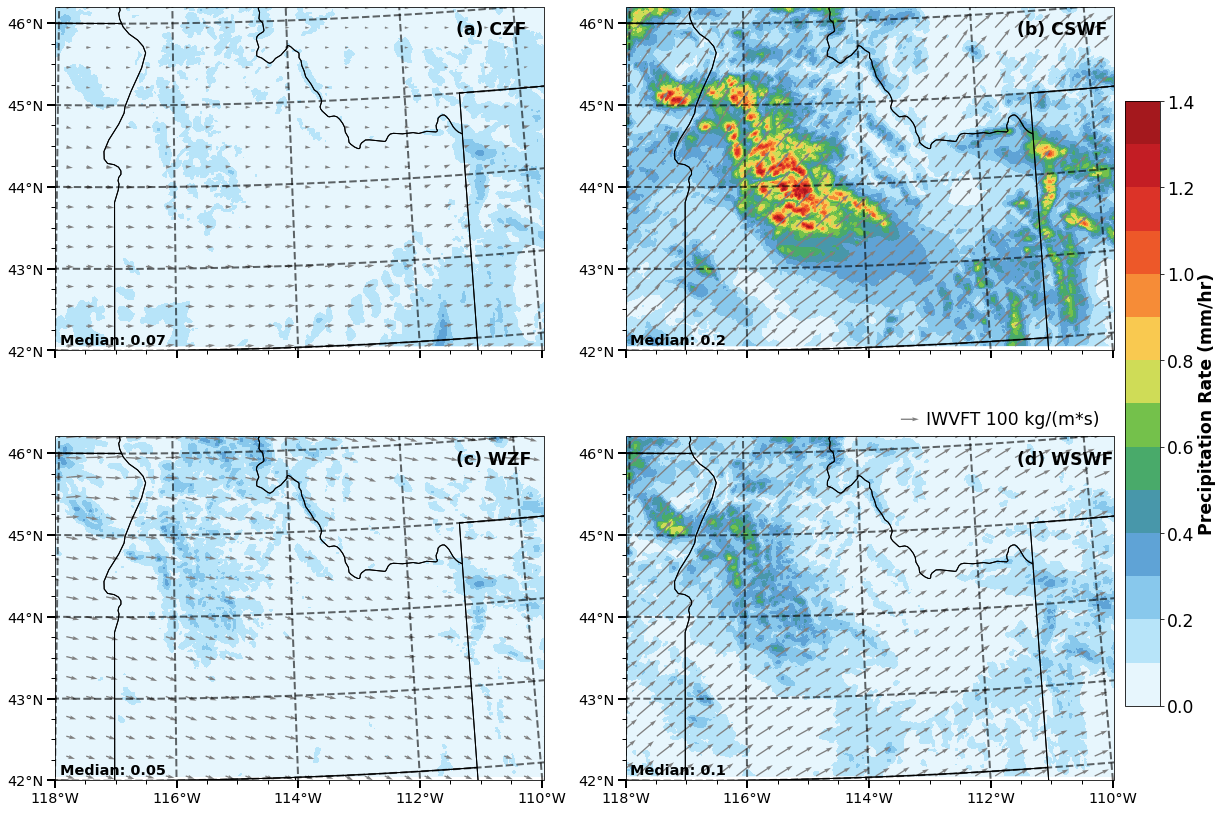

In [10]:
%%time
# #-- Visulaize the composite ground precip rate (WRF output) projected onto the SOM model and its associated integrated water vapor transportation
#-#

## get the map projection
wrffile  = Dataset("/glade/work/zhixing/wrfout_d02_2017-01-01_00:00:00")
terrain  = getvar(wrffile, 'ter', timeidx=ALL_TIMES, method = "cat")
mapcrs  = get_cartopy(terrain) ## Lambert projection
datacrs = ccrs.PlateCarree() 

## plotting
fig, axs = plt.subplots(2,2, figsize=(16,12), sharey=True, sharex = True, subplot_kw = {'projection':mapcrs})
for i in range(2):
    for j in range(2):
        ## extract the composite data in each pattern
        ax = axs[i, j]
        IVMFT_u_data = dic_IVMFT_u_map[(i, j)]; IVMFT_v_data = dic_IVMFT_v_map[(i, j)]
        pcp_data     = np.mean(dic_pcp_map[(i,j)], axis=0); 
        map_extent   = [-118, -109.95, 42, 46]
        ax.set_extent(map_extent, crs = datacrs) ## set the size of map region
        ax.add_feature(cfeature.COASTLINE.with_scale('50m')) ## add the coastline features
        ax.add_feature(cfeature.STATES.with_scale('50m')) ## add the state boundary
        
        ## ground precipitation distribution plot
        max_pcp  = pcp_data.max()
        lvls     = np.arange(0, 1.41, 0.1) ## set the contour levels for the shaded maps
        pcp_map  = ax.contourf(lons_big_area, lats_big_area, pcp_data, cmap = cmaps.WhiteBlueGreenYellowRed, levels = lvls, transform = datacrs) ## plot color-filled contour
        
        print("max: ", np.nanmax(pcp_data), " mean: ", np.nanmean(pcp_data), " median: ", np.nanmedian(pcp_data) )
        max_pcp_data = np.nanmax(pcp_data); mean_pcp_data = np.nanmean(pcp_data); median_pcp_data = np.nanmedian(pcp_data)  ## maximum; mean; median values
        # ax.text(.01, .15, 'Max: '+ str(round(max_pcp_data,3)), ha='left', va='top', transform=ax.transAxes, fontsize = 'x-large', fontweight = 'bold')
        # ax.text(.01, .10, 'Mean: '+ str(round(mean_pcp_data,3)), ha='left', va='top', transform=ax.transAxes, fontsize = 'x-large', fontweight = 'bold')
        ax.text(.01, .05, 'Median: '+ str(round(median_pcp_data,2)), ha='left', va='top', transform=ax.transAxes, fontsize = 'x-large', fontweight = 'bold') ## add median value in left-bottom corner

        
        ## integrated water vapor transport plot (arrows)
        IVMFT_slice = (slice(None, None, 30), slice(None, None, 30)) ## since the data is very dense, we choose some reasonable intervals to visualize the data
        IVMFT_bar = ax.quiver(lons_big_area.data[IVMFT_slice], lats_big_area.data[IVMFT_slice],IVMFT_u_data[IVMFT_slice],\
                            IVMFT_v_data[IVMFT_slice], color='gray', transform=datacrs, scale_units = 'inches', scale = 400)
        if (i,j) == (1,1):
            qk = ax.quiverkey(IVMFT_bar, 0.6, 1.05, 100, r'IWVFT 100 kg/(m*s)', labelpos='E',
                       coordinates='axes', fontproperties={'size':'xx-large'})  ## add the arrow symbol for the integrated water vapor flux
            
        ## *must* call draw in order to get the axis boundary used to add ticks:
        fig.canvas.draw()
        xticks = list(np.arange(-118,-108,2)); yticks = list(np.arange(42,47,1))
        ax.gridlines(xlocs=xticks, ylocs=yticks,linestyle='--',lw=2,color='k',alpha=0.6)# dimgrey
                
        ## Label the end-points of the gridlines using the custom tick makers:
        ax.yaxis.set_major_formatter(LATITUDE_FORMATTER); ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
        """xx-small 5.79; x-small 6.94; small 8.33; medium 10.0; large 12.0; x-large 14.4; xx-large 17.28; larger 12.0; smaller 8.33"""
        # https://stackoverflow.com/questions/30030328/correct-placement-of-colorbar-relative-to-geo-axes-cartopy
        lambert_yticks(ax, yticks); lambert_xticks(ax, xticks)
        
        ## some parameter setting for ticks
        ax.tick_params(axis='both',  length=8, width=2, labelsize='x-large', right=False, left=True, labelright=False, labelleft=True)
        ax.tick_params(which='minor',length=4, width=1,labelsize='x-large')
        ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
        ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
        
## tick parameters        
label_list = ['(a) CZF', '(b) CSWF', '(c) WZF', '(d) WSWF']
ax_title0  = axs[0,0].text(.82, .96, label_list[0], ha='left', va='top', transform=axs[0,0].transAxes, fontsize = 'xx-large', fontweight = 'bold')
ax_title1  = axs[0,1].text(.80, .96, label_list[1], ha='left', va='top', transform=axs[0,1].transAxes, fontsize = 'xx-large', fontweight = 'bold')
ax_title2  = axs[1,0].text(.82, .96, label_list[2], ha='left', va='top', transform=axs[1,0].transAxes, fontsize = 'xx-large', fontweight = 'bold')
ax_title3  = axs[1,1].text(.80, .96, label_list[3], ha='left', va='top', transform=axs[1,1].transAxes, fontsize = 'xx-large', fontweight = 'bold')

## add the colorbar and its labels
cax  = plt.axes([0.98, 0.15, 0.03, 0.7]); cbar = fig.colorbar(pcp_map, cax = cax); cbar.ax.tick_params(labelsize='xx-large') 
cbar.set_label(label='Precipitation Rate (mm/hr)', weight='bold', fontsize='xx-large')
fig.tight_layout(h_pad=4.0)